In [1]:
#-------------------------------
# Step 0. Setting up the imports
#-------------------------------
import numpy as np

# Import Qiskit packages
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options, Session

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum", instance="executive/internal/main")

# Define backend
use_real = True

if use_real:
    backend = service.backend('ibmq_kolkata')
else:
    backend = service.backend('ibmq_qasm_simulator')

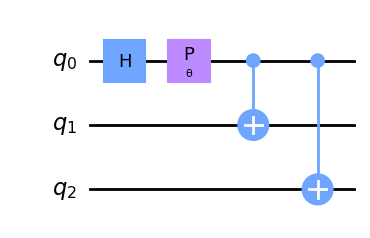

In [2]:
#---------------------------
# Step 1. circuit selection 
#---------------------------
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
theta = Parameter('θ')


# Step 1. Choose the quantum circuit to make the quantum state |000> + e^{theta} |111>
qc_example = QuantumCircuit(3)
qc_example.h(0) # generate superposition
qc_example.p(theta, 0) # add quantum phase
qc_example.cx(0, 1) # condition 1st qubit on 0th qubit
qc_example.cx(0, 2) # condition 2nd qubit on 0th qubit
qc_example.draw('mpl')

In [3]:
#------------------------------
# Step 2. Problem specification
#------------------------------
from qiskit.quantum_info import SparsePauliOp

# Step 2: Choose the output to be measured
M1 = SparsePauliOp.from_list([("XXY", 1), ("XYX", 1), ("YXX", 1), ("YYY", -1)])

print(M1)

SparsePauliOp(['XXY', 'XYX', 'YXX', 'YYY'],
              coeffs=[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j])


In [4]:
#------------------------------------
# Step 3. Execute using the Estimator
#------------------------------------

options = Options(optimization_level=1)
options.execution.shots = 5000  # Options can be set using auto-complete.

# golden search method for finding max of M1 vs theta 
# https://en.wikipedia.org/wiki/Golden-section_search
gr = (np.sqrt(5) + 1) / 2

# range of theta  
thetaa = 0
thetab = 2*np.pi

#tol 
tol = 1e-1

with Session(backend=backend) as session:
    estimator = Estimator(options=options)

    #next test range 
    thetac = thetab - (thetab - thetaa) / gr
    thetad = thetaa + (thetab - thetaa) / gr
    while abs(thetab - thetaa) > tol:
        
        print(f"min value of M1 is in the range theta = {[thetaa, thetab]}")
        job = estimator.run(circuits=[qc_example]*2, observables=[M1]*2, parameter_values=[[thetac],[thetad]])
        
        test =job.result().values
        if test[0] < test[1]:
            thetab = thetad
        else:
            thetaa = thetac
        
        thetac = thetab - (thetab - thetaa) / gr
        thetad = thetaa + (thetab - thetaa) / gr
        
    # Final Job to evaluate estimator at mid point found using golden search method 
    theta_mid = (thetab + thetaa) / 2
    job = estimator.run(circuits=qc_example, observables=M1, parameter_values=theta_mid)
    print(f"Session ID is {session.session_id}")
    print(f"Final Job ID is {job.job_id()}")
    print(f"Job result is {job.result().values} at theta = {theta_mid}")

min value of M1 is in the range theta = [0, 6.283185307179586]
min value of M1 is in the range theta = [2.3999632297286535, 6.283185307179586]
min value of M1 is in the range theta = [3.883222077450933, 6.283185307179586]
min value of M1 is in the range theta = [3.883222077450933, 5.366480925173213]
min value of M1 is in the range theta = [3.883222077450933, 4.799926459457307]
min value of M1 is in the range theta = [4.2333719937414, 4.799926459457307]
min value of M1 is in the range theta = [4.4497765431668395, 4.799926459457307]
min value of M1 is in the range theta = [4.4497765431668395, 4.666181092592279]
min value of M1 is in the range theta = [4.53243572572725, 4.666181092592279]
Session ID is cjf3nt6nq2dtf2799s00
Final Job ID is cjf66dmnq2dtf27d4vl0
Job result is [-3.87985502] at theta = 4.624851501312072


In [5]:
np.linalg.eigvalsh(M1.to_matrix())[0]

-4.0

In [6]:
4.624851501312074/3.14

1.4728826437299598